In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## 1. Load the Data

In [11]:
# Load dataset
df = pd.read_csv("C:\\Users\\Sowmy\\Downloads\\final_named_filtered_dataset (1).csv")
print(df.head)


<bound method NDFrame.head of       country_code       country  year  gdp_health_expenditure  \
0              ARG     Argentina  2010                   5.572   
1              ARG     Argentina  2010                   5.572   
2              ARG     Argentina  2010                   5.572   
3              ARG     Argentina  2010                   5.572   
4              ARG     Argentina  2010                   5.572   
...            ...           ...   ...                     ...   
24859          ZAF  South Africa  2021                   4.087   
24860          ZAF  South Africa  2021                   4.087   
24861          ZAF  South Africa  2021                   4.087   
24862          ZAF  South Africa  2021                   4.087   
24863          ZAF  South Africa  2021                   4.087   

       political_corruption_index  cause_id                       cause_name  \
0                           0.545       491          Cardiovascular diseases   
1                

From the above dataset we can see that there are 11 columns where gdp health expenditure means the percentage of a countrys GDP spent on health for that particular year , Political corruption index tells how much coruruption is there in a country's government it is a numeric value between 0 and 1 where 0 mwans lows corruption and 1 means high corruption.Cause name column shows the specific disease which caused death. And metric used are percent and rate where percent means the percentage of people who died from a spefic cause. Rate means the number of deaths per 100,000 people from that disease.

In [13]:
# Filter and pivot to get rates
pivot_df = df[df['metric'] == 'Rate'].pivot_table(
    index=['country', 'year'],
    columns='cause_name',
    values='value'
)
print(pivot_df.head())

# Standardize
scaler = StandardScaler()
X_full = scaler.fit_transform(pivot_df.values)

cause_name      Cardiovascular diseases  Chronic respiratory diseases  \
country   year                                                          
Argentina 2010               228.254111                     45.208357   
          2011               227.414544                     45.874043   
          2012               224.117218                     44.527249   
          2013               220.492910                     42.467901   
          2014               216.972915                     42.161881   

cause_name      Diabetes and kidney diseases  Digestive diseases  \
country   year                                                     
Argentina 2010                     62.673461           33.708803   
          2011                     62.520470           34.273235   
          2012                     61.749046           34.757385   
          2013                     61.256145           35.578368   
          2014                     60.202058           36.540073   

cause_name 

## 2. SVD Analysis

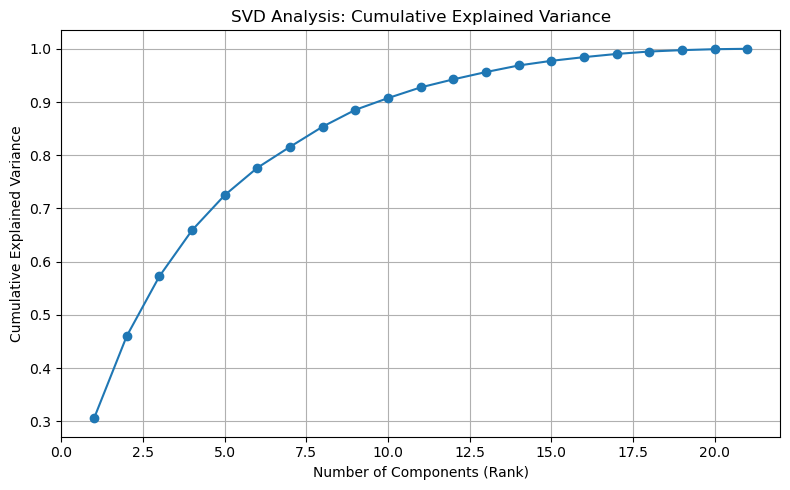

In [14]:
U, S, VT = np.linalg.svd(X_full, full_matrices=False)
explained_variance = (S**2) / np.sum(S**2)
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(S)+1), cumulative_variance, marker='o')
plt.title("SVD Analysis: Cumulative Explained Variance")
plt.xlabel("Number of Components (Rank)")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Interpretation of the Scree PLot**

**Shape of the curve**

The curve increases sharply at the beginning, indicating that the first few singular values explain most of the variance in the dataset. The 10% of the components captures around 90% of the variance. After rank 15, the gain falttens out.

**Dimensionality Reduction**

Since the first 10 components capture the majority of the structure in the data, We can reduce dimensionality to rank 10 without losing much information.

**Elbow Point**

There's a noticeable "elbow" or inflection point around rank 6–8. Using ranks in the range of 6–10 is likely optimal for balancing performance and complexity.

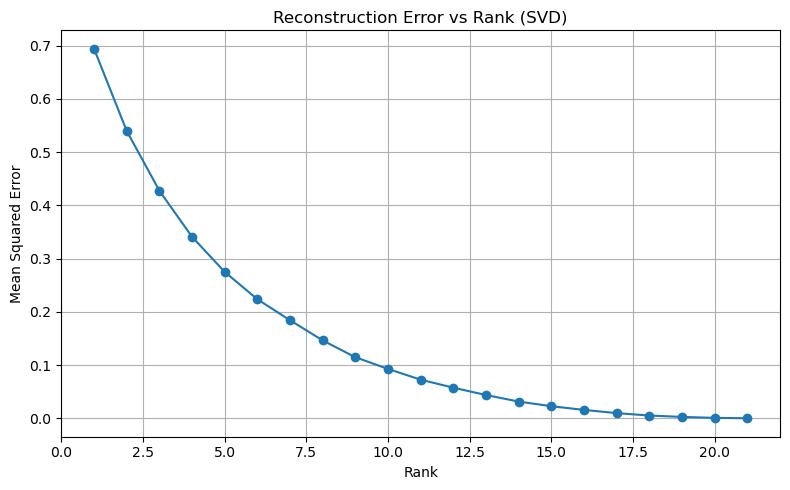

In [15]:

# Plot reconstruction error vs rank
errors = []
for r in range(1, len(S)+1):
    S_approx = np.zeros_like(S)
    S_approx[:r] = S[:r]
    X_approx = U @ np.diag(S_approx) @ VT
    mse = np.mean((X_full - X_approx) ** 2)
    errors.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(S)+1), errors, marker='o')
plt.title("Reconstruction Error vs Rank (SVD)")
plt.xlabel("Rank")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Interpretation of Reconstruction Error Vs rank plot**

**Shape of the curve**

The curve is steep at first, bends into an elbow and flattens out as error decreases rapidly from rank 1 to ~10, indicating that the first few singular vectors capture the majority of the structure in the data.

**Elbow Point**

Around rank 10 is an elbow, it is a natural cutoff where additional components improve the reconstruction only slightly. 



## 3. SVD Matrix Completion

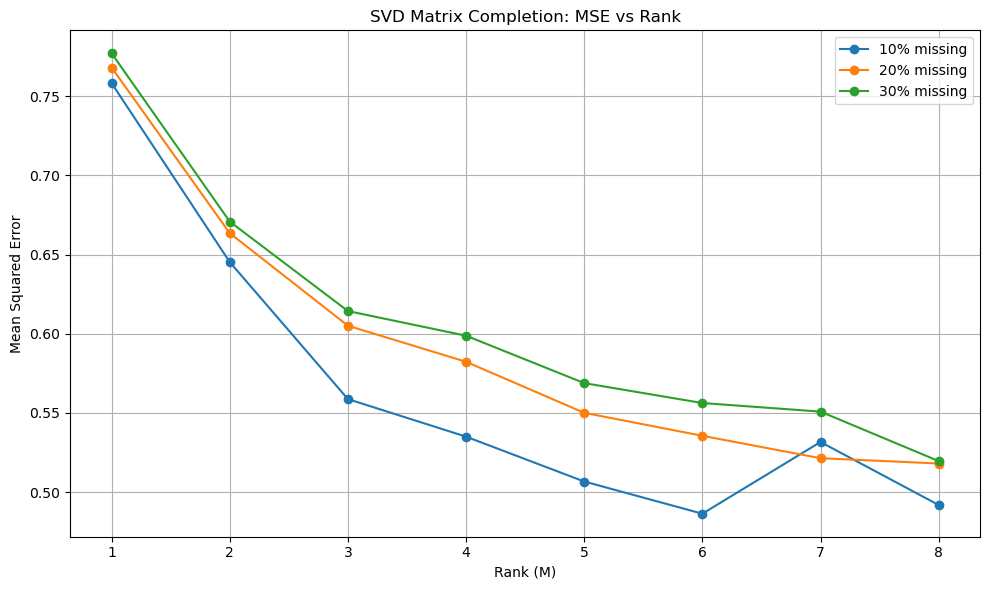

In [3]:
missing_rates = [0.1, 0.2, 0.3]
rank_range = range(1, 9)
results = {}

for missing_rate in missing_rates:
    np.random.seed(42)
    X_missing = X_full.copy()
    mask = np.random.rand(*X_missing.shape) < missing_rate
    X_missing[mask] = np.nan
    missing_mask = np.isnan(X_missing)

    col_means = np.nanmean(X_missing, axis=0)
    inds = np.where(np.isnan(X_missing))

    errors = []
    for rank in rank_range:
        Xhat = X_missing.copy()
        Xhat[inds] = np.take(col_means, inds[1])

        for _ in range(5):
            U, S, VT = np.linalg.svd(Xhat, full_matrices=False)
            S[rank:] = 0
            Xapp = U @ np.diag(S) @ VT
            Xhat[missing_mask] = Xapp[missing_mask]

        mse = np.mean((Xapp[missing_mask] - X_full[missing_mask])**2)
        errors.append(mse)

    results[missing_rate] = errors

plt.figure(figsize=(10, 6))
for rate, error_list in results.items():
    plt.plot(rank_range, error_list, marker='o', label=f'{int(rate*100)}% missing')
plt.title("SVD Matrix Completion: MSE vs Rank")
plt.xlabel("Rank (M)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **MSE vs Rank for SVD Matrix Completion Plot**

This plot shows how SVD rank affects matrix completion under different missing data levels (10%, 20%, 30%).We measured performance using Mean Squared Error (MSE), lower values mean better reconstruction. 

As expected, increasing the SVD rank improves the accuracy of matrix completion. The MSE drops quickly from rank 1 to 4, then the improvement becomes slower, especially after rank 6, showing smaller gains. The model works best when there is less missing data — the 10% missing line (blue) has the lowest MSE, followed by 20% and 30%.

For 10% missing data, there is a slight increase in MSE at rank 7, which may be due to overfitting or instability when using higher ranks. Overall, the results show that higher ranks improve recovery, less missing data leads to better results, and ranks between 6 and 8 offer a good balance.

## 4. Compare Imputation Quality ( Rank 6 vs Rank 8)

def svd_impute(X, rank, missing_mask):
    X_filled = X.copy()
    for _ in range(5):
        U, S, VT = np.linalg.svd(X_filled, full_matrices=False)
        S[rank:] = 0
        X_approx = U @ np.diag(S) @ VT
        X_filled[missing_mask] = X_approx[missing_mask]
    return X_filled

# Create 10% missing data
np.random.seed(42)
X_missing = X_full.copy()
mask = np.random.rand(*X_missing.shape) < 0.1
X_missing[mask] = np.nan
missing_mask = np.isnan(X_missing)

# Mean imputation to initialize
col_means = np.nanmean(X_missing, axis=0)
inds = np.where(np.isnan(X_missing))
Xhat = X_missing.copy()
Xhat[inds] = np.take(col_means, inds[1])

# Impute with rank 6 and rank 8
X_rank6 = svd_impute(Xhat, rank=6, missing_mask=missing_mask)
X_rank8 = svd_impute(Xhat, rank=8, missing_mask=missing_mask)

# True and imputed values
true_vals = X_full[missing_mask]
imputed_vals_6 = X_rank6[missing_mask]
imputed_vals_8 = X_rank8[missing_mask]

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(true_vals, imputed_vals_6, alpha=0.5)
plt.plot([true_vals.min(), true_vals.max()],
         [true_vals.min(), true_vals.max()], 'r--')
plt.title("Rank = 6")
plt.xlabel("True Values")
plt.ylabel("Imputed Values")

plt.subplot(1, 2, 2)
plt.scatter(true_vals, imputed_vals_8, alpha=0.5)
plt.plot([true_vals.min(), true_vals.max()],
         [true_vals.min(), true_vals.max()], 'r--')
plt.title("Rank = 8")
plt.xlabel("True Values")
plt.ylabel("Imputed Values")

plt.suptitle("SVD Imputation: Rank-6 vs Rank-8 (10% Missing)")
plt.tight_layout()
plt.show()

# MSE scores
print(f"MSE (Rank=6): {np.mean((true_vals - imputed_vals_6)**2):.4f}")
print(f"MSE (Rank=8): {np.mean((true_vals - imputed_vals_8)**2):.4f}")


#### SVD Imputation Comparison: Rank 6 vs Rank 8

We compared matrix completion using SVD at **rank 6** and **rank 8** on data with **10% missing values**. Rank 6 gave better results with a lower mean squared error. Even though rank 8 used more information, it didn’t improve the accuracy. This shows that rank 6 is not only simpler but also more effective for this task.


## 5. K-Means Clustering and PCA Visualization

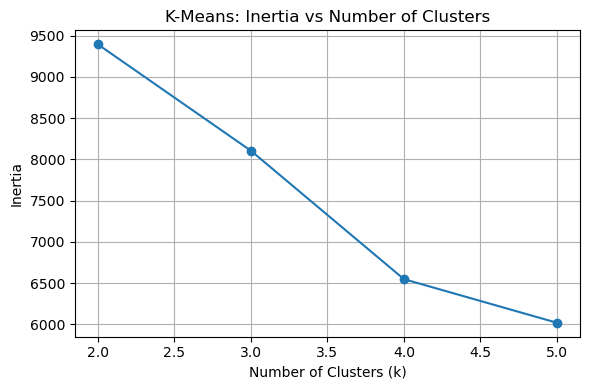

In [23]:

#Test different values of k 
X_imputed = X_rank6

inertias = []
silhouette_scores = []
k_range = range(2, 6)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_imputed)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_imputed, labels))

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("K-Means: Inertia vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()





####  **K-Means: Inertia vs Number of Clusters Plot**

We plotted inertia for k = 2 to 5. Inertia drops significantly from k=2 to k=4. After k=4, the decrease is much smaller, indicating diminishing returns.

The "elbow point" occurs at **k = 4**, so we selected 4 clusters for our final K-Means model.


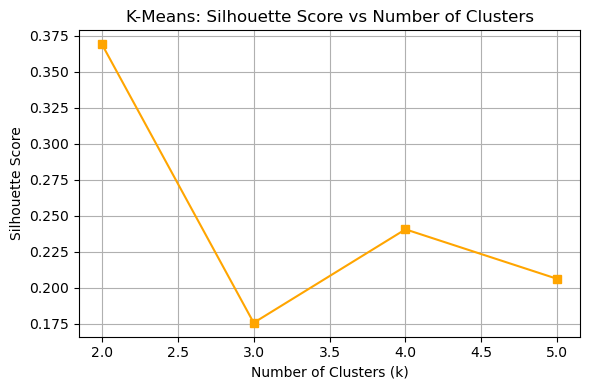

In [24]:
#Silhouette Score
plt.figure(figsize=(6, 4))
plt.plot(k_range, silhouette_scores, marker='s', color='orange')
plt.title("K-Means: Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


####  **K-Means: Silhouette score vs Number of Clusters Plot**

From the plot we can see when k=2, it has the highest score (~0.37), but it may oversimplify the data. k=3 drops sharply this indicates poor separation. k=4 improves again, this suggests more meaningful groupings.k=5 shows a slight decline.

Therefore ,**k=4** is a good option  it balances cluster quality (silhouette) and structure (from the inertia elbow).

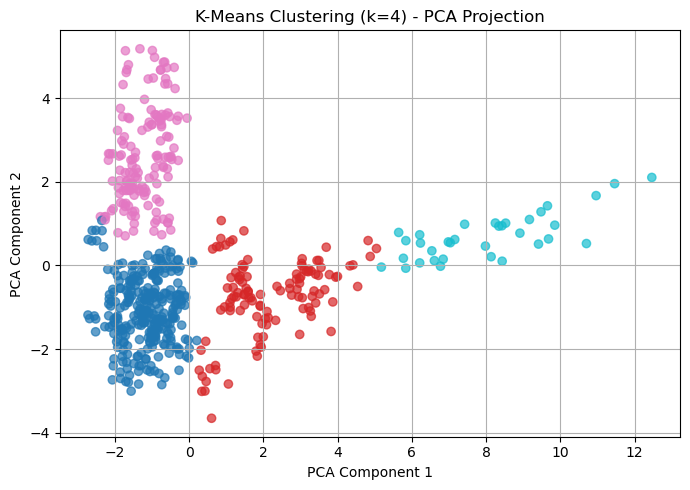

In [26]:
# Final clustering
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_imputed)

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_imputed)

plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title(f"K-Means Clustering (k={k_optimal}) - PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

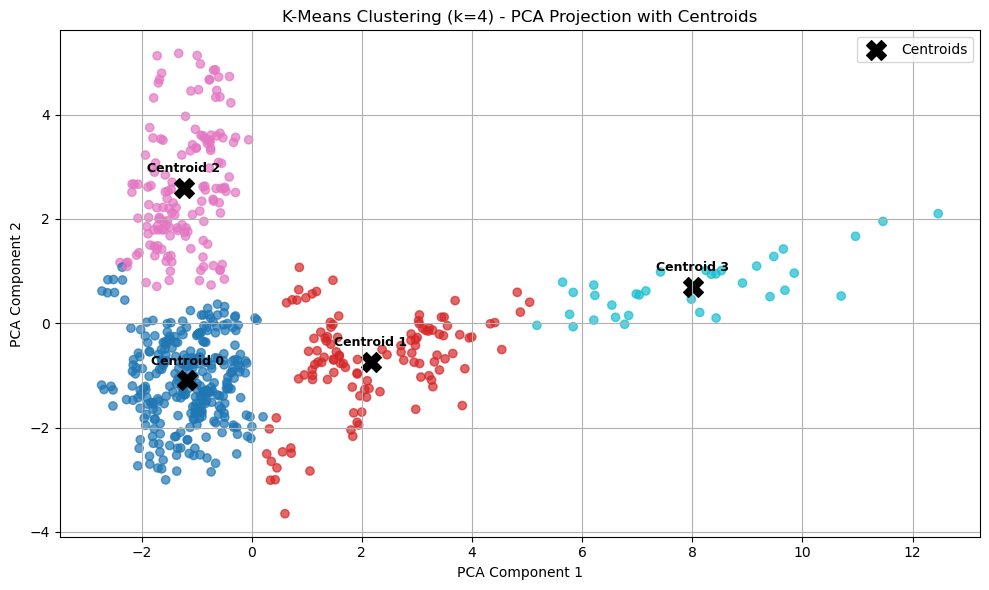

In [32]:
centroids = kmeans_final.cluster_centers_
centroids_2d = pca.transform(centroids)

#Visualization
plt.figure(figsize=(10, 6))

# Plot data points
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)

# Plot centroids
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            marker='X', s=200, c='black', label='Centroids')

# Annotate centroids
for i, (x, y) in enumerate(centroids_2d):
    plt.text(x, y + 0.3, f'Centroid {i}', ha='center', fontsize=9, weight='bold')

# Final plot details
plt.title(f"K-Means Clustering (k={k_optimal}) - PCA Projection with Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In the PCA and K-Means cluster plot,shows clear separation between the groups. One group, labeled Cluster 3, is positioned far to the right, meaning the countries in this cluster are quite different from the others based on the first principal component. Clusters 0 and 1 are close to each other in the plot. Among them, Cluster 0 appears more compact, which means the countries in that group are more similar to each other.



In [46]:
pivot_df = pivot_df.copy()
pivot_df['cluster'] = cluster_labels
pivot_df.reset_index(inplace=True)  # Bring back 'country' and 'year' as columns
cluster_groups = pivot_df.groupby('cluster')[['country', 'year']].apply(lambda x: x.reset_index(drop=True))
for cluster_num in range(4):
    print(f"\n Cluster {cluster_num} includes:")
    print(pivot_df[pivot_df['cluster'] == cluster_num][['country', 'year']].head(10))
cluster_summary = pivot_df.groupby('cluster')['country'].unique()

for cluster_id, countries in cluster_summary.items():
    print(f"\n Cluster {cluster_id} includes countries:")
    print(", ".join(sorted(set(countries))))



 Cluster 0 includes:
cause_name    country  year
12          Australia  2010
13          Australia  2011
14          Australia  2012
15          Australia  2013
16          Australia  2014
17          Australia  2015
18          Australia  2016
19          Australia  2017
20          Australia  2018
21          Australia  2019

 Cluster 1 includes:
cause_name    country  year
0           Argentina  2010
1           Argentina  2011
2           Argentina  2012
3           Argentina  2013
4           Argentina  2014
5           Argentina  2015
6           Argentina  2016
7           Argentina  2017
8           Argentina  2018
9           Argentina  2019

 Cluster 2 includes:
cause_name   country  year
58          Bulgaria  2010
59          Bulgaria  2011
60          Bulgaria  2012
61          Bulgaria  2013
62          Bulgaria  2014
63          Bulgaria  2015
64          Bulgaria  2016
65          Bulgaria  2017
66          Bulgaria  2018
67          Bulgaria  2019

 Cluster 3 includes:

Looking at the countries in each cluster, we found that 
- Cluster 0 includes developed countries such as the United States, Germany, Australia, the United Kingdom, Canada, and Japan.
- Cluster 3 includes countries like India, Indonesia, and South Africa, which seem to follow different patterns compared to the rest.
-  Cluster 1 groups together countries such as Argentina, Brazil, Chile, and Türkiye, which are generally upper-middle income.
-  Cluster 2 contains countries like Bulgaria, Romania, and Ukraine, which are mostly from Eastern Europe.

## 6. Cluster Profiling with Policy Indicators

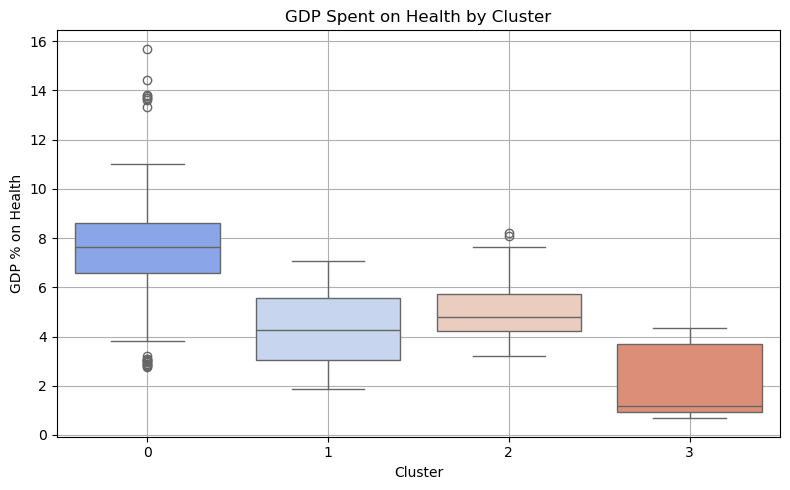

In [48]:
#cluster profiling
policy_df = df[df['metric'] == 'Rate'].copy()
policy_df = policy_df.drop_duplicates(subset=['country', 'year'])
policy_df = policy_df[['country', 'year', 'gdp_health_expenditure', 'political_corruption_index']]
pivot_with_policy = pivot_df.merge(policy_df, on=['country', 'year'], how='left')

plt.figure(figsize=(8, 5))
sns.boxplot(data=pivot_with_policy, x='cluster', y='gdp_health_expenditure', palette='coolwarm')
plt.title("GDP Spent on Health by Cluster")
plt.xlabel("Cluster")
plt.ylabel("GDP % on Health")
plt.grid(True)
plt.tight_layout()
plt.show()




To explore how healthcare investment varies across clusters, we looked at the percentage of GDP each country spends on health. The box plot shows that Cluster 0 includes developed countries like the United States, Germany, and Japan, and has the highest health spending, with most countries spending between 6% and 10% of their GDP on health. Some even exceed 13%, making this group stand out in terms of healthcare investment.

Cluster 1 includes countries like Brazil, Argentina, and Chile, and spends around 3% to 6% of GDP on health. Cluster 2 contains many Eastern European countries such as Romania and Bulgaria, with spending mostly between 4% and 6%.

Cluster 3 is made up of countries like India, Indonesia, and South Africa, and spends the least, with most values falling between 1% and 4%, and a median close to 2%. This pattern suggests that economic capacity and investment in healthcare play a significant role in how countries are grouped in our clustering analysis.

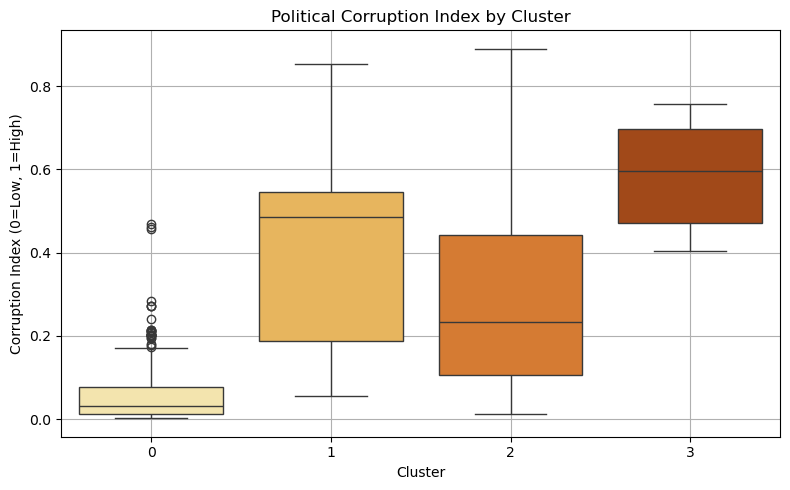

In [51]:
#ploitical corruptuon index.
plt.figure(figsize=(8, 5))
sns.boxplot(data=pivot_with_policy, x='cluster', y='political_corruption_index', palette='YlOrBr')
plt.title("Political Corruption Index by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Corruption Index (0=Low, 1=High)")
plt.grid(True)
plt.tight_layout()
plt.show()


We also examined the Political Corruption Index, where 0 means low corruption and 1 means high corruption. The results show that Cluster 0 has the lowest levels of corruption, with most countries scoring below 0.1. This cluster includes many high-income, well-governed nations.

Cluster 1 shows a wide range of corruption, with scores mostly between 0.1 and 0.8, and a median around 0.5. Cluster 2 also has varied corruption levels, but its median is slightly lower, close to 0.25.

Cluster 3 has the highest levels of corruption overall, with most countries scoring between 0.4 and 0.75, and a median above 0.6. This pattern suggests that countries grouped in Cluster 3 may face more serious governance challenges compared to those in the other clusters.

## 7. Top Causes of Death per Cluster

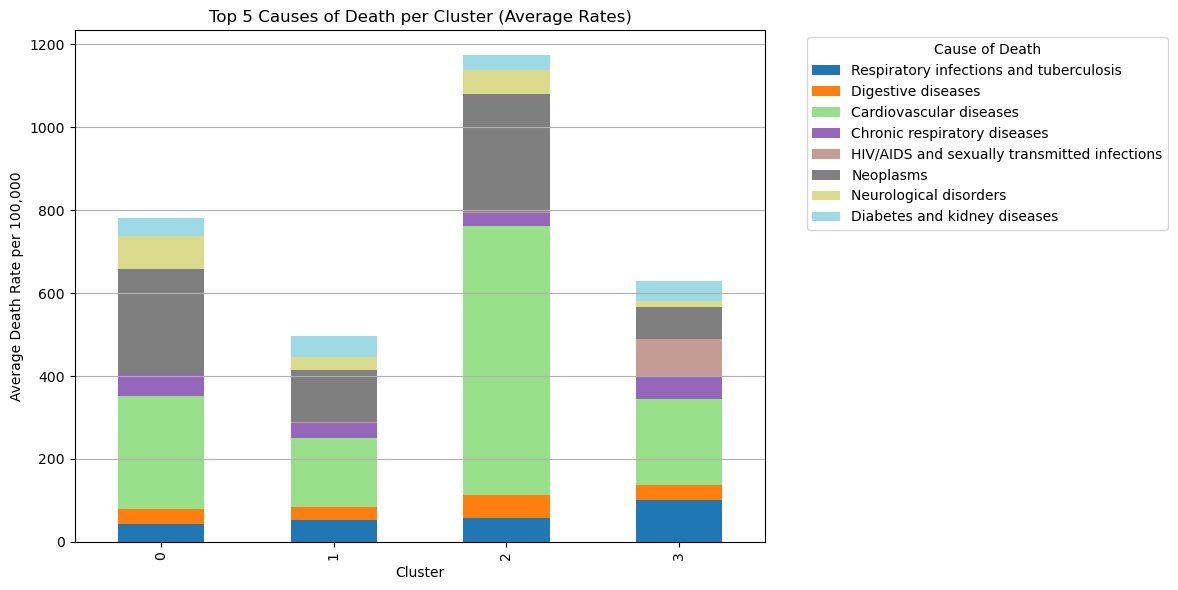

In [7]:

cause_columns = [col for col in pivot_df.columns if col not in ['country', 'year', 'cluster']]
avg_by_cluster = pivot_df.groupby('cluster')[cause_columns].mean().T

top_5_causes = set()
for cluster_id in avg_by_cluster.columns:
    top_5 = avg_by_cluster[cluster_id].sort_values(ascending=False).head(5).index.tolist()
    top_5_causes.update(top_5)

top_5_causes = list(top_5_causes)
top_cause_rates = avg_by_cluster.loc[top_5_causes]

top_cause_rates.T.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Top 5 Causes of Death per Cluster (Average Rates)")
plt.xlabel("Cluster")
plt.ylabel("Average Death Rate per 100,000")
plt.legend(title="Cause of Death", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The chart shows that causes of death vary by cluster. Cluster 0 has high rates of cardiovascular diseases and cancers, typical of high-income countries. Cluster 1 shows similar causes but with lower overall rates. Cluster 2 has the highest death rates, mainly due to cardiovascular issues. Cluster 3 includes more deaths from infectious diseases like respiratory infections and HIV/AIDS, common in lower-income countries. This highlights how health priorities differ by region and development level.

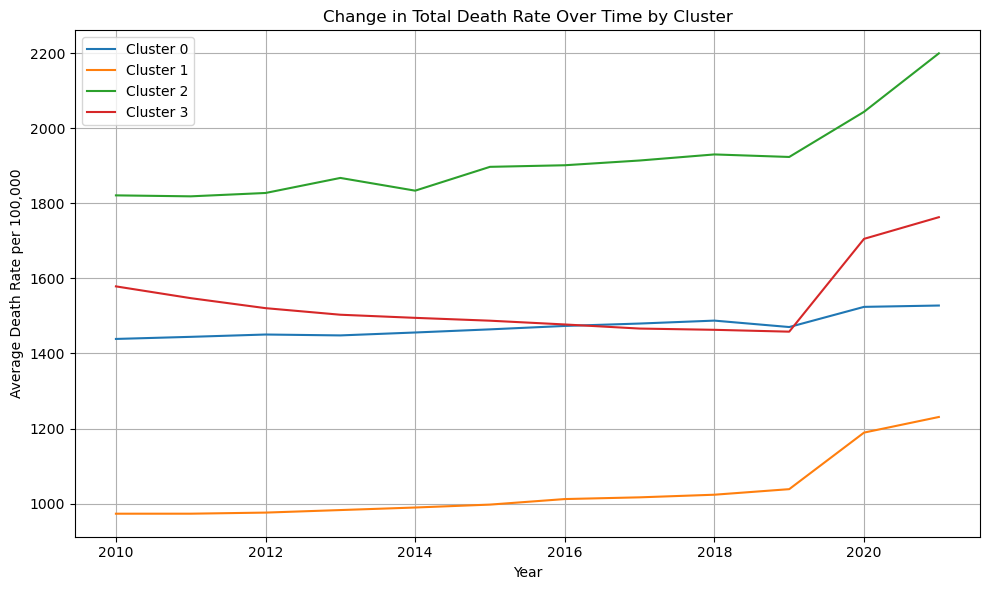

In [54]:
# Total death rate per row 
pivot_df['total_death_rate'] = pivot_df[cause_columns].sum(axis=1)

# Group by cluster and year to get average total death rate
avg_trend = pivot_df.groupby(['cluster', 'year'])['total_death_rate'].mean().reset_index()

# Plot trends by cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(pivot_df['cluster'].unique()):
    cluster_data = avg_trend[avg_trend['cluster'] == cluster_id]
    plt.plot(cluster_data['year'], cluster_data['total_death_rate'], label=f"Cluster {cluster_id}")

plt.title("Change in Total Death Rate Over Time by Cluster")
plt.xlabel("Year")
plt.ylabel("Average Death Rate per 100,000")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The chart shows distinct trends across the four clusters from 2010 to 2021. Cluster 2 consistently had the highest death rates, with a noticeable increase after 2019, possibly reflecting rising non-communicable disease burdens or effects from global health crises. Cluster 3 showed a decline until 2019, followed by a sharp increase, which may suggest a recent rise in health challenges like infectious diseases or healthcare system stress. Cluster 0 maintained relatively stable death rates over time, while Cluster 1 had the lowest rates throughout the period but has shown a gradual upward trend, especially after 2019. These patterns highlight how health outcomes are evolving differently across groups of countries and may inform where more intervention is needed.

## Conclusion

By combining PCA, clustering, and matrix completion, we uncovered distinct groups of countries with shared health profiles. High-income nations showed higher non-communicable disease rates and health spending, while lower-income clusters faced more infectious diseases, lower investment, and higher corruption. 